
Adaptation/modification of em459's [code](https://bitbucket.org/em459/neuralode/src/master/ )    to workout the forcing function f, for the ODE problem,

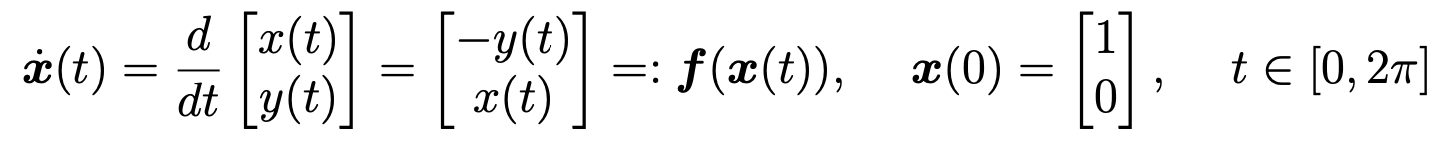
using a neural network.


**NOTE**: This code is just for experimentation/explanation purposes for my thesis only and is not intended to be a demonstration of my coding ability.

In [ ]:
# Imports

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
tf.keras.backend.set_floatx('float32')

In [ ]:
"""
####################################################
em459's RK4 code
####################################################
"""

class RK4(keras.layers.Layer):

    def __init__(self,f_layer,h):
        super(RK4, self).__init__()
        self.f_layer = f_layer
        self.h = h

    def call(self, inputs, record_trajectories = False):
        # Number of samples
        N = inputs.get_shape().as_list()[0]
        # Dimension of input vector y
        dim = inputs.get_shape().as_list()[1]-1
        
        # Extract initial conditions and stopping times
        yt = tf.unstack(inputs,axis=1)
        t_stop = yt[-1]
        # Set initial condition for RK4 integrator
        y_hat = tf.stack(yt[0:dim],axis=1)
        # Find largest stopping time
        t_max = tf.math.reduce_max(t_stop)
        if (record_trajectories):
            # Number of timesteps
            M = int(np.floor((t_max+0.5*self.h)/self.h))
            self.y_traj = np.zeros((N,dim,M+1))
            self.y_traj[:,:,0] = y_hat.numpy()[:,:]
        t = 0.0
        k_step = 1
        # Integrate
        while(t < t_max-0.5*self.h):
            k1 = self.f_layer(y_hat)
            k2 = self.f_layer(y_hat+0.5*self.h*k1)
            k3 = self.f_layer(y_hat+0.5*self.h*k2)
            k4 = self.f_layer(y_hat+self.h*k3)

            s_mask = tf.stack([tf.cast(t<t_stop-0.5*self.h, tf.float32)], axis = 1)
            mask = tf.repeat(s_mask,repeats=dim,axis=1)
            y_hat += self.h/6.0*tf.math.multiply(k1+2*k2+2*k3+k4,mask)
            if (record_trajectories):
                self.y_traj[:,:,k_step] = y_hat.numpy()[:,:]
            t += self.h
            k_step += 1
        return y_hat


In [ ]:
# Forcing Model

class Forcing(keras.Model):
  
  def __init__(self, latent_dim, **kwargs):
    super(Forcing, self).__init__(**kwargs)
    self.latent_dim = latent_dim
    self.layer1 = layers.Dense(2)

  def call(self, input):
    return self.layer1(input)

In [ ]:
"""
####################################################
Modifcation of em459's exact model
####################################################
"""

# Exact Model

class Exact(keras.Model):

    def y_exact(self,t):
        return (np.cos(t), np.sin(t))


    def generate_data(self,N):
        t_stop = np.random.uniform(low = 0, high = 2*np.pi, size = N)
    
        X, Y = self.y_exact(t_stop)
        
        x_data = np.zeros((N,3))
        x_data[:,0] = np.ones(N)
        x_data[:,1] = np.zeros(N)
        x_data[:,2] = t_stop

        y_data = np.zeros((N,2))
        y_data[:,0] = X
        y_data[:,1] = Y

        return x_data, y_data

In [ ]:
# Constructing exact ODE model

spiral = Exact()

In [ ]:
# Number of data points
N = 12800

# Generating data
x_train, y_train = spiral.generate_data(N)

In [ ]:
batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(N).batch(batch_size)

In [ ]:
# Constructing ODE solver

f_dampedho = Forcing(2)
h = 0.01 # Timestep size
model = RK4(f_dampedho,h)

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.01)
loss_fn = tf.keras.losses.MeanSquaredError()

epochs = 4

# Train over number of epochs
for epoch in range(epochs):
    print ("\nStart of epoch %d" % (epoch+1,))
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            y_batch_pred = model(x_batch_train)
            loss_value = loss_fn(y_batch_pred, y_batch_train)
        grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        if step % 50 == 0:
          print(
              "Training loss (for one batch) at step %4d: %.4f"
              % (step, float(loss_value)))



Start of epoch 1
Training loss (for one batch) at step    0: 1.7875
Training loss (for one batch) at step   50: 0.5938
Training loss (for one batch) at step  100: 0.5016
Training loss (for one batch) at step  150: 0.4075

Start of epoch 2
Training loss (for one batch) at step    0: 0.2067
Training loss (for one batch) at step   50: 0.0319
Training loss (for one batch) at step  100: 0.0052
Training loss (for one batch) at step  150: 0.0005

Start of epoch 3
Training loss (for one batch) at step    0: 0.0002
Training loss (for one batch) at step   50: 0.0003
Training loss (for one batch) at step  100: 0.0004
Training loss (for one batch) at step  150: 0.0001

Start of epoch 4
Training loss (for one batch) at step    0: 0.0014
Training loss (for one batch) at step   50: 0.0005
Training loss (for one batch) at step  100: 0.0005
Training loss (for one batch) at step  150: 0.0005


In [ ]:
# Plotting

from matplotlib import pyplot as plt

In [ ]:
# Exact plot test data

time = np.linspace(0,2*np.pi, 1000)
y_exact = np.array([np.cos(time), np.sin(time)])

In [ ]:
# Mode plot test data

N = 1000
x_data = np.zeros((N,3))
x_data[:,0] = np.ones(N)
x_data[:,1] = np.zeros(N)
x_data[:,2] = time

In [ ]:
y_pred = model(x_data, record_trajectories = True)

In [ ]:
from matplotlib.pyplot import figure

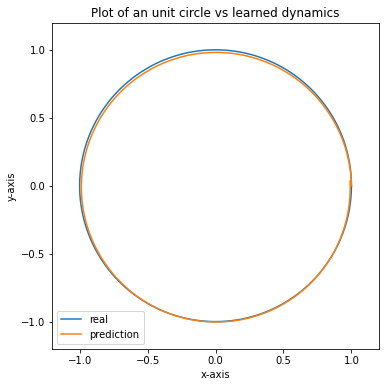

In [ ]:
figure(figsize=(6,6))
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(y_exact[0], y_exact[1], label = "real")
plt.plot(y_pred[:,0], y_pred[:,1], label = "prediction")
plt.ylabel("y-axis")
plt.xlabel("x-axis")
plt.title("Plot of an unit circle vs learned dynamics")
plt.legend(loc="lower left")
plt.show()

In [ ]:
# Trained models varaiables 

model.trainable_variables

[<tf.Variable 'r_k4/forcing/dense/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.00401455,  1.0066111 ],
        [-1.0053495 ,  0.00105759]], dtype=float32)>,
 <tf.Variable 'r_k4/forcing/dense/bias:0' shape=(2,) dtype=float32, numpy=array([-0.01326977, -0.00417622], dtype=float32)>]

In [ ]:
# Collecting 

ep1 = [1.7875, 0.5938,0.5016, 0.4075]
ep2 = [0.2067,0.0319, 0.0052, 0.0005]
ep3 = [0.0002, 0.0003, 0.0004, 0.0001]
ep4 = [0.0014, 0.0005, 0.0005, 0.0005]
batch = [0, 50, 100, 150]

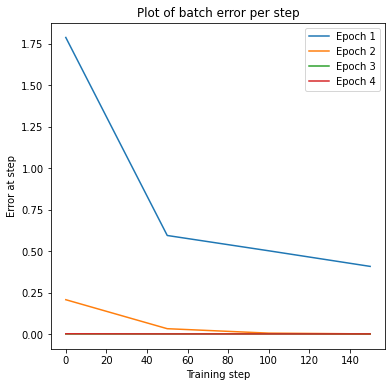

In [ ]:
# Plotting Error over training

figure(figsize=(6,6))
plt.plot(batch, ep1, label = "Epoch 1")
plt.plot(batch, ep2, label = "Epoch 2")
plt.plot(batch, ep3, label = "Epoch 3")
plt.plot(batch, ep4, label = "Epoch 4")
plt.ylabel("Error at step")
plt.xlabel("Training step")
plt.legend(loc="upper right")
plt.title("Plot of batch error per step")
plt.show()